In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

!pip install keras-tuner
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam

!pip install scikeras
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


# **R2**

## load dataset and data processing

In [ ]:
train_file = '/content/drive/My Drive/Colab Notebooks/Machine Learning/Homeworks/HW1/r2_200_100k.csv'
df_train = pd.read_csv(train_file, sep=';', header=0)
print('Train file loaded, samples: %d' %(df_train.shape[0]))
print('training dataset:\n')
print(df_train.head())

test_file = '/content/drive/My Drive/Colab Notebooks/Machine Learning/Homeworks/HW1/r2_400_100k.csv'
df_test = pd.read_csv(test_file, sep=';', header=0)
print('\n\n\nTest file loaded, samples: %d' %(df_test.shape[0]))
print('testing dataset:\n')
print(df_test.head())


from sklearn.model_selection import train_test_split

print('\n\n')
X = df_train[['j0', 'j1', 'cos(j0)', 'cos(j1)', 'sin(j0)', 'sin(j1)']].values # features
Y = df_train[['ft_x', 'ft_y', 'ft_qw', 'ft_qz']].values # target
# Dividi i dati in training e validation set
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X_train: ', X_train.shape, '\tY_train: ', Y_train.shape, '\n')
print('X_val: ', X_val.shape, '\tY_val: ', Y_val.shape, '\n')

X_test = df_test[['j0', 'j1', 'cos(j0)', 'cos(j1)', 'sin(j0)', 'sin(j1)']].values # features
Y_test = df_test[['ft_x', 'ft_y', 'ft_qw', 'ft_qz']].values # target
print('X_test: ', X_test.shape, '\tY_test: ', Y_test.shape)

Train file loaded, samples: 100000
training dataset:

      j0     j1  cos(j0)  cos(j1)  sin(j0)  sin(j1)  ft_x   ft_y  ft_qw  ft_qz
0  0.029  0.033    1.000    0.999    0.029    0.033  0.21  0.010  1.000  0.031
1  0.041  0.046    0.999    0.999    0.041    0.046  0.21  0.014  0.999  0.043
2  0.027  0.046    1.000    0.999    0.027    0.046  0.21  0.011  0.999  0.036
3 -0.019  0.025    1.000    1.000   -0.019    0.025  0.21 -0.001  1.000  0.003
4 -0.055 -0.002    0.998    1.000   -0.055   -0.002  0.21 -0.012  1.000 -0.029



Test file loaded, samples: 100000
testing dataset:

      j0     j1  cos(j0)  cos(j1)  sin(j0)  sin(j1)   ft_x   ft_y  ft_qw  \
0 -0.060  0.022    0.998    1.000   -0.060    0.022  0.210 -0.010  1.000   
1 -0.084  0.031    0.996    1.000   -0.084    0.031  0.209 -0.014  1.000   
2 -0.093  0.039    0.996    0.999   -0.093    0.039  0.209 -0.015  1.000   
3 -0.078  0.011    0.997    1.000   -0.078    0.011  0.209 -0.015  0.999   
4 -0.082 -0.056    0.997    0.998   -

In [ ]:
# normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
# convert into TensorFlow tensors (float32)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)

X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)

X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.float32)

In [ ]:
# select a random subset of the samples

train_indices = np.random.choice(X_train.shape[0], size=1000, replace=False)
X_train = tf.convert_to_tensor(X_train.numpy()[train_indices], dtype=tf.float32)
Y_train = tf.convert_to_tensor(Y_train.numpy()[train_indices], dtype=tf.float32)

val_indices = np.random.choice(X_val.shape[0], size=1000, replace=False)
X_val = tf.convert_to_tensor(X_val.numpy()[val_indices], dtype=tf.float32)
Y_val = tf.convert_to_tensor(Y_val.numpy()[val_indices], dtype=tf.float32)

print('X_train: ', X_train.shape, '\tY_train: ', Y_train.shape, '\n')
print('X_val: ', X_val.shape, '\tY_val: ', Y_val.shape, '\n')

X_train:  (1000, 6) 	Y_train:  (1000, 4) 

X_val:  (1000, 6) 	Y_val:  (1000, 4) 



## model (linear regression)

### model definition

In [ ]:
# Gradient Descent-based Linear Regression


# Linear Regression Model
class LinearRegressionModel(tf.keras.Model):
    def __init__(self, input_dim, output_dim, **kwargs):
        super(LinearRegressionModel, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = tf.keras.layers.Dense(output_dim, activation=None, use_bias=True)

    def call(self, inputs):
        return self.linear(inputs)

    # methods for saving the model (serialization/deserialization)
    def get_config(self):
        # save model configuration
        config = super(LinearRegressionModel, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "output_dim": self.output_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        # recreate the model from the configuration
        return cls(**config)



### training - hyperparameter tuning

In [ ]:
def build_model(hp):
    input_dim = 6  # Number of features ( j0, j1, cos(j0), cos(j1), sin(j0), sin(j1) )
    output_dim = 4  # Number of outputs ( ft_x, ft_y, ft_qw, ft_qz )

    model = LinearRegressionModel(input_dim, output_dim)

    # Hyperparameters to tune
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
    epochs = hp.Int('epochs', min_value=50, max_value=200, step=10)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')

    return model

# tuner
tuner = kt.RandomSearch(
    build_model,  # function that builds the model
    objective='val_loss',  # objective to optimize
    max_trials=6,  # number of combinations
    executions_per_trial=1,  # number of tests
    directory='keras_tuner_data_r2_lin',  # directory name for tuner data
)

# hyperparameter search
tuner.search(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best epochs: {best_hps.get('epochs')}\n\n")



# saving the best model
best_model = build_model(best_hps)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
                   loss='mean_squared_error')
history = best_model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                         epochs=best_hps.get('epochs'), batch_size=32)

best_model.save('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Homeworks/HW1/r2_lin_fk.keras')

Trial 6 Complete [00h 00m 04s]
val_loss: 1.023643970489502

Best val_loss So Far: 0.4572044014930725
Total elapsed time: 00h 00m 22s
Best learning rate: 0.005457694546162564
Best epochs: 110


Epoch 1/110
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0252 - val_loss: 0.6092
Epoch 2/110
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5554 - val_loss: 0.3571
Epoch 3/110
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3238 - val_loss: 0.2515
Epoch 4/110
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2341 - val_loss: 0.2027
Epoch 5/110
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1880 - val_loss: 0.1776
Epoch 6/110
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1666 - val_loss: 0.1632
Epoch 7/110
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1566 - val_loss: 0.1545
Epoch 8/110
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1521 - val_loss: 0.1500
Epoch 9/110
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1424 - val_loss: 0.1474
Epoch 10/110
32/32 ━━━━━━━━━━━━━━━━

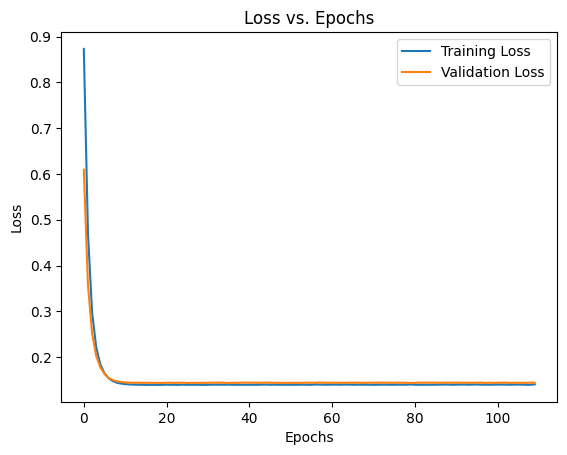

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

### testing

In [ ]:
# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Homeworks/HW1/r2_lin_fk.keras', custom_objects={'LinearRegressionModel': LinearRegressionModel})

# Predict on the test set
Y_pred_test = model.predict(X_test)

# MSE
test_loss = tf.reduce_mean(tf.square(Y_test - Y_pred_test)).numpy()
print(f"\nLoss on test set: {test_loss:.4f}")



3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

Loss on test set: 0.1430


In [ ]:
# Comparison between learned Jacobian and analytical Jacobian

# FK prediction
def FK(model, theta):
    # Reshape to batch size 1
    t = tf.reshape(theta, shape=(1, 6))  # 6-dimensional input
    out = model(t)[:, :2]  # take only first two values predicted (ft_x, ft_y)
    # Reshape to 1D vector
    out = tf.reshape(out, shape=(2,))  # 2-dimensional output (ft_x, ft_y)
    return out

# learned Jacobian
@tf.function
def FK_Jacobian(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = FK(model, x)
    return tape.jacobian(y, x)[:, :2]  # consider only the first two elements (j0, j1)


# analytical Jacobian
def analytical_jacobian(theta, L1, L2):
    theta1, theta2 = theta[0], theta[1]   # joint angles

    J11 = -L1 * np.sin(theta1) - L2 * np.sin(theta1 + theta2)
    J12 = -L2 * np.sin(theta1 + theta2)
    J21 = L1 * np.cos(theta1) + L2 * np.cos(theta1 + theta2)
    J22 = L2 * np.cos(theta1 + theta2)

    J = np.array([[J11, J12], [J21, J22]])
    return J


# link lengths
L1 = 0.1
L2 = 0.1
# single test sample
sample_input = X_test[0]
print("input sample:\t", sample_input.numpy())

from tabulate import tabulate

analytical_jacobian_matrix = analytical_jacobian(sample_input, L1, L2)
print("\nANALYTICAL JACOBIAN MATRIX:\n")
print(tabulate(analytical_jacobian_matrix, tablefmt="fancy_grid"))

fk_output = FK(model, sample_input)
learned_jacobian_matrix = FK_Jacobian(model, sample_input)
print("\nForward Kinematics Output (FK):", fk_output.numpy())
print("\nLEARNED JACOBIAN MATRIX:")
print(tabulate(learned_jacobian_matrix.numpy(), tablefmt="fancy_grid"))



# -------------------------------------------------------------------- Comparison
print("\n\nCOMPARISON between learned jacobian and analytical jacobian:\n")

# Function to compare the learned Jacobian with the analytical one
def compare_jacobians(learned_jacobian, analytical_jacobian):
    # Frobenius norm of the difference
    elementwise_diff = learned_jacobian - analytical_jacobian # element-wise differences
    frobenius_norm = np.linalg.norm(elementwise_diff, 'fro')

    return frobenius_norm, elementwise_diff


# Comparison
frobenius_norm, elementwise_diff = compare_jacobians(learned_jacobian_matrix.numpy(), analytical_jacobian_matrix)
print(f"Frobenius norm of the difference: {frobenius_norm}\n")
print("Element-wise difference:\n")
print(tabulate(elementwise_diff, tablefmt="fancy_grid"))




input sample:	 [-0.02098687 -0.03345539  1.7309977   1.6827176  -0.08761874 -0.00471709]

ANALYTICAL JACOBIAN MATRIX:

╒════════════╤════════════╕
│ 0.00754007 │ 0.00544154 │
├────────────┼────────────┤
│ 0.19983    │ 0.0998518  │
╘════════════╧════════════╛

Forward Kinematics Output (FK): [ 4.2555992e-02 -1.3798475e-05]

LEARNED JACOBIAN MATRIX:
╒═════════════╤═════════════╕
│ -0.0117037  │  0.00470325 │
├─────────────┼─────────────┤
│  0.00446344 │ -0.00050724 │
╘═════════════╧═════════════╛


COMPARISON between learned jacobian and analytical jacobian:

Frobenius norm of the difference: 0.22047864250617313

Element-wise difference:

╒════════════╤══════════════╕
│ -0.0192438 │ -0.000738288 │
├────────────┼──────────────┤
│ -0.195366  │ -0.100359    │
╘════════════╧══════════════╛


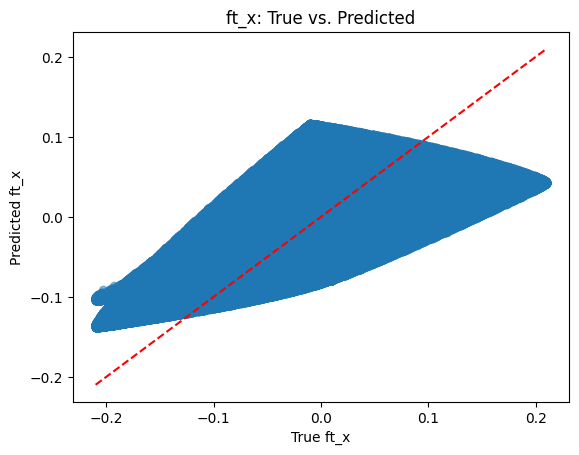

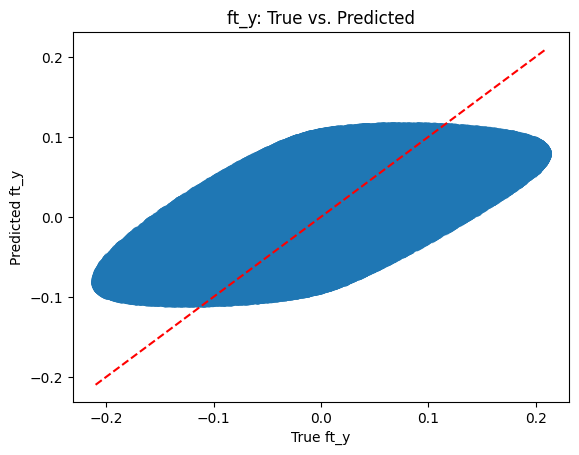

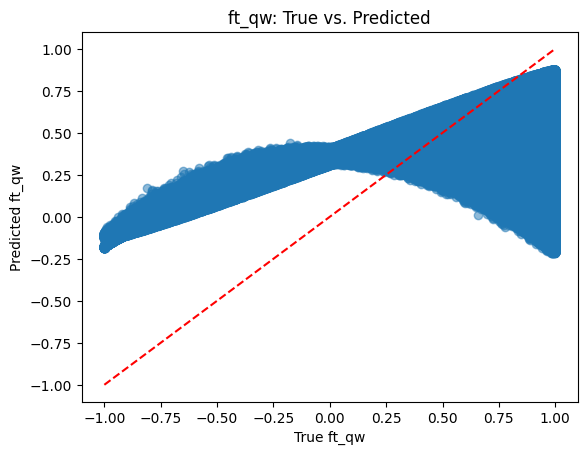

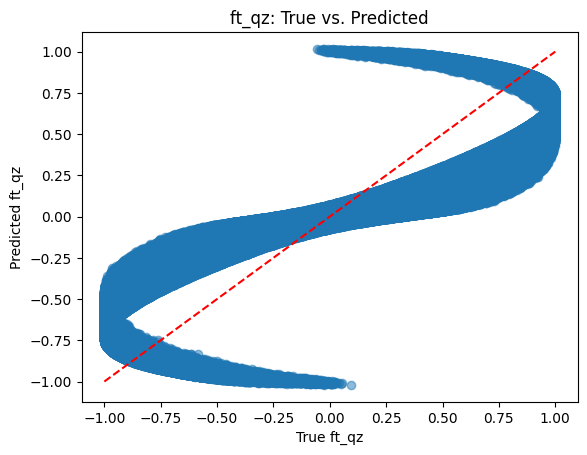

In [ ]:
# convert tensors in numpy arrays
Y_test_np = Y_test.numpy() if hasattr(Y_test, 'numpy') else Y_test
Y_pred_test_np = Y_pred_test.numpy() if hasattr(Y_pred_test, 'numpy') else Y_pred_test

for i, label in enumerate(['ft_x', 'ft_y', 'ft_qw', 'ft_qz']):
    plt.scatter(Y_test_np[:, i], Y_pred_test_np[:, i], alpha=0.5)
    plt.plot([Y_test_np[:, i].min(), Y_test_np[:, i].max()],
             [Y_test_np[:, i].min(), Y_test_np[:, i].max()], 'r--')
    plt.xlabel(f'True {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'{label}: True vs. Predicted')
    plt.show()

## model (polynomial regression)

### model definition

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

class PolynomialRegressionModel(tf.keras.Model):
    def __init__(self, input_dim, output_dim, **kwargs):
        super(PolynomialRegressionModel, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = tf.keras.layers.Dense(output_dim, activation=None, use_bias=True)

    def call(self, inputs):
        return self.linear(inputs)

    def get_config(self):
        config = super(PolynomialRegressionModel, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "output_dim": self.output_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)



In [ ]:
# polynomial features for all degrees
poly_features = {}
for degree in range(1, 6):
    poly = PolynomialFeatures(degree)
    poly_features[degree] = {
        "X_train": tf.convert_to_tensor(poly.fit_transform(X_train.numpy()), dtype=tf.float32),
        "X_val": tf.convert_to_tensor(poly.transform(X_val.numpy()), dtype=tf.float32),
        "X_test": tf.convert_to_tensor(poly.transform(X_test.numpy()), dtype=tf.float32),
    }

### training - hyperparameter tuning

In [ ]:
def build_poly_model(hp):
    # polynomial degree
    degree = hp.Int('degree', min_value=1, max_value=5, step=1)

    X_train_poly = poly_features[degree]["X_train"]
    X_val_poly = poly_features[degree]["X_val"]

    # Input dimension for polynomial features
    input_dim_poly = X_train_poly.shape[1]

    # learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
    # number of epochs
    epochs = hp.Int('epochs', min_value=50, max_value=150, step=10)

    # Create and compile the model
    model = PolynomialRegressionModel(input_dim=input_dim_poly, output_dim=4)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')

    return model


tuner = kt.RandomSearch(
    build_poly_model,
    objective='val_loss',
    max_trials=6,
    executions_per_trial=1,
    directory='keras_tuner_data_r2_poly'
)

tuner.search(poly_features[1]["X_train"], Y_train, validation_data=(poly_features[1]["X_val"], Y_val), batch_size=32)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best polynomial degree: {best_hps.get('degree')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best epochs: {best_hps.get('epochs')}\n\n")



# Train the best model for polynomial regression
model = build_poly_model(best_hps)
best_degree = best_hps.get('degree')
X_train_poly = poly_features[best_degree]["X_train"]
X_val_poly = poly_features[best_degree]["X_val"]
history = model.fit(X_train_poly, Y_train,
                      validation_data=(X_val_poly, Y_val),
                      epochs=best_hps.get('epochs'), batch_size=32)


model.save('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Homeworks/HW1/r2_poly_fk.keras')



Trial 6 Complete [00h 00m 02s]
val_loss: 0.7540584206581116

Best val_loss So Far: 0.7540584206581116
Total elapsed time: 00h 00m 11s
Best polynomial degree: 2
Best learning rate: 0.005081982303663561
Best epochs: 140


Epoch 1/140
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7148 - val_loss: 0.7068
Epoch 2/140
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5192 - val_loss: 0.2358
Epoch 3/140
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1706 - val_loss: 0.0826
Epoch 4/140
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0605 - val_loss: 0.0347
Epoch 5/140
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271 - val_loss: 0.0181
Epoch 6/140
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160 - val_loss: 0.0114
Epoch 7/140
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - val_loss: 0.0082
Epoch 8/140
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0065
Epoch 9/140
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 10/140
3

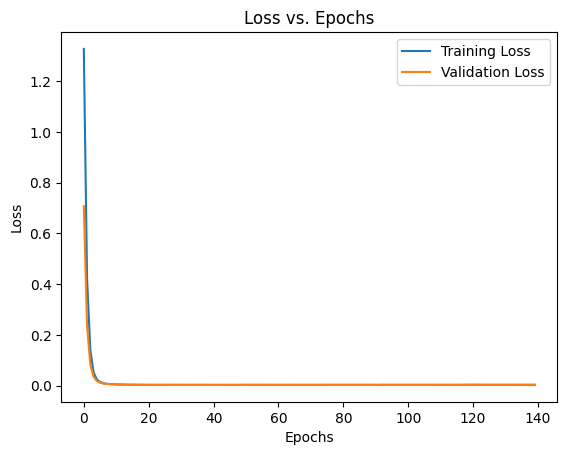

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
#plt.ylim(0, 0.01)
plt.show()

### testing

In [ ]:
# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Homeworks/HW1/r2_poly_fk.keras', custom_objects={'PolynomialRegressionModel': PolynomialRegressionModel})


# Predict on the test set
X_test_poly = poly_features[best_hps.get('degree')]["X_test"]
Y_pred_test = model.predict(X_test_poly)

# MSE
test_loss = tf.reduce_mean(tf.square(Y_test - Y_pred_test)).numpy()
print(f"\nLoss on test set: {test_loss:.6f}")



3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Loss on test set: 0.003337


In [ ]:
# Comparison between learned Jacobian and analytical Jacobian
from itertools import combinations_with_replacement

# FK prediction
def FK(model, theta):
    # Reshape to batch size 1
    t = tf.reshape(theta, shape=(1, X_train_poly.shape[1]))
    out = model(t)[:, :2]  # take only first two values predicted (ft_x, ft_y)
    # Reshape to 1D vector
    out = tf.reshape(out, shape=(2,))  # 2-dimensional output
    return out

@tf.function
def FK_Jacobian(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = FK(model, x)
    return tape.jacobian(y, x)[:, :2]  # consider only the first two elements (j0, j1)

def poly_transform(sample, degree):
    poly_features = [tf.ones((sample.shape[0], 1), dtype=tf.float32)]  # Constant term (intercept)
    for degree in range(1, best_degree+1):
        for comb in combinations_with_replacement(range(sample.shape[1]), degree):
            feature_comb = tf.reduce_prod([sample[:, i] for i in comb], axis=0, keepdims=True)
            poly_features.append(feature_comb)

    # Concatenate all features
    poly_features_tensor = tf.concat(poly_features, axis=1)
    return poly_features_tensor

@tf.function
def poly_original_Jacobian(sample, degree):
    sample = tf.reshape(sample, shape=(1, -1))

    with tf.GradientTape(persistent=False) as tape:
        tape.watch(sample)
        poly_features = poly_transform(sample, degree)

    return tape.jacobian(poly_features, sample)


# analytical Jacobian
def analytical_jacobian(theta, L1, L2):
    theta1, theta2 = theta[0], theta[1]   # joint angles

    J11 = -L1 * np.sin(theta1) - L2 * np.sin(theta1 + theta2)
    J12 = -L2 * np.sin(theta1 + theta2)
    J21 = L1 * np.cos(theta1) + L2 * np.cos(theta1 + theta2)
    J22 = L2 * np.cos(theta1 + theta2)

    J = np.array([[J11, J12], [J21, J22]])
    return J



# link lengths
L1 = 0.1
L2 = 0.1
# single test sample
sample_input = X_test[0]
print("input sample:\t", sample_input.numpy())
# polynomial transformation
poly = PolynomialFeatures(best_degree)
sample_input_poly = poly.fit_transform(sample_input.numpy().reshape(1, -1))
sample_input_poly = tf.convert_to_tensor(sample_input_poly, dtype=tf.float32)

from tabulate import tabulate

analytical_jacobian_matrix = analytical_jacobian(sample_input, L1, L2)
print("\nANALYTICAL JACOBIAN MATRIX:\n")
print(tabulate(analytical_jacobian_matrix, tablefmt="fancy_grid"))

fk_output = FK(model, sample_input_poly)
print("\nForward Kinematics Output (FK):", fk_output.numpy())
# learned Jacobian in polynomial feature space
poly_jacobian_matrix = tf.squeeze(FK_Jacobian(model, sample_input_poly), axis=1)  # dy / dx_poly
# compute Jacobian from polynomial features to originale features
poly_original_j_matrix = tf.squeeze(poly_original_Jacobian(sample_input, best_degree), axis=(0, 2))[:, :2]  # dx_poly / dx

learned_jacobian_matrix = tf.matmul(poly_jacobian_matrix, poly_original_j_matrix)   # dy / dx
print("\nLEARNED JACOBIAN MATRIX:")
print(tabulate(learned_jacobian_matrix.numpy(), tablefmt="fancy_grid"))



# -------------------------------------------------------------------- Comparison
print("\n\nCOMPARISON between learned jacobian and analytical jacobian:\n")

# Function to compare the learned Jacobian with the analytical one
def compare_jacobians(learned_jacobian, analytical_jacobian):
    # norm of the difference
    elementwise_diff = learned_jacobian - analytical_jacobian # element-wise differences
    norm = np.linalg.norm(elementwise_diff, 'fro')

    return norm, elementwise_diff


# Comparison
norm, elementwise_diff = compare_jacobians(learned_jacobian_matrix.numpy(), analytical_jacobian_matrix)
print(f"Norm of the difference: {norm}\n")
print("Element-wise difference:\n")
print(tabulate(elementwise_diff, tablefmt="fancy_grid"))


input sample:	 [-0.02098687 -0.03345539  1.7309977   1.6827176  -0.08761874 -0.00471709]

ANALYTICAL JACOBIAN MATRIX:

╒════════════╤════════════╕
│ 0.00754007 │ 0.00544154 │
├────────────┼────────────┤
│ 0.19983    │ 0.0998518  │
╘════════════╧════════════╛

Forward Kinematics Output (FK): [ 0.20871897 -0.00760843]

LEARNED JACOBIAN MATRIX:
╒═════════════╤════════════╕
│ -0.0214871  │ -0.0191284 │
├─────────────┼────────────┤
│ -0.00623041 │  0.137068  │
╘═════════════╧════════════╛


COMPARISON between learned jacobian and analytical jacobian:

Norm of the difference: 0.2128194353661327

Element-wise difference:

╒════════════╤════════════╕
│ -0.0290271 │ -0.02457   │
├────────────┼────────────┤
│ -0.20606   │  0.0372161 │
╘════════════╧════════════╛


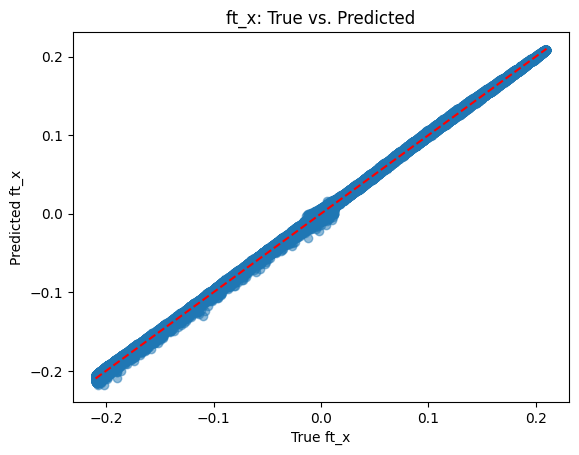

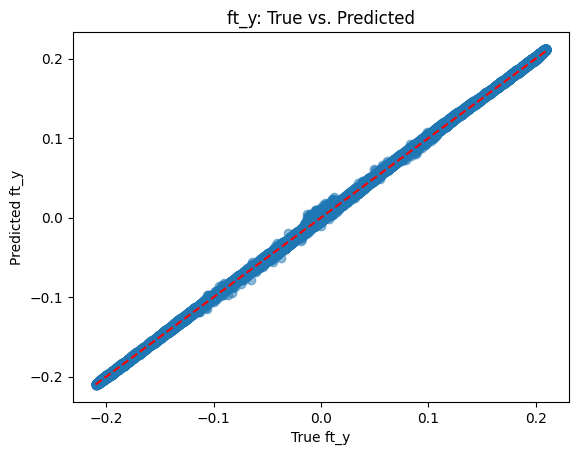

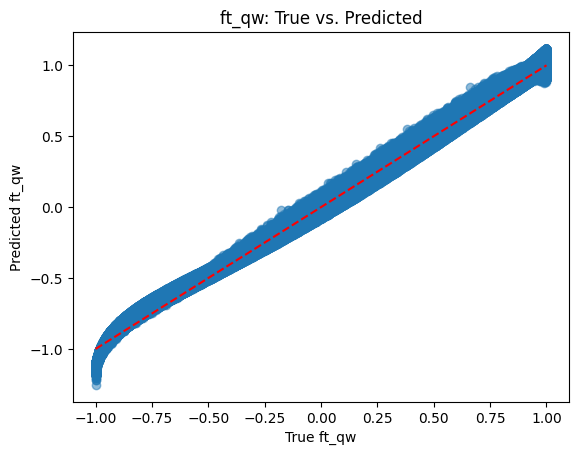

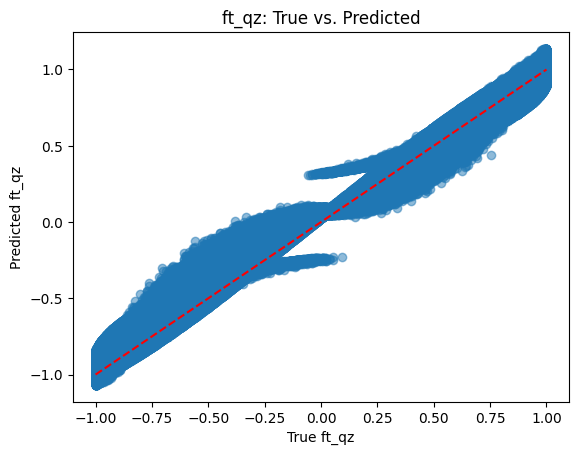

In [ ]:
# convert tensors in numpy arrays
Y_test_np = Y_test.numpy() if hasattr(Y_test, 'numpy') else Y_test
Y_pred_test_np = Y_pred_test.numpy() if hasattr(Y_pred_test, 'numpy') else Y_pred_test

for i, label in enumerate(['ft_x', 'ft_y', 'ft_qw', 'ft_qz']):
    plt.scatter(Y_test_np[:, i], Y_pred_test_np[:, i], alpha=0.5)
    plt.plot([Y_test_np[:, i].min(), Y_test_np[:, i].max()],
             [Y_test_np[:, i].min(), Y_test_np[:, i].max()], 'r--')
    plt.xlabel(f'True {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'{label}: True vs. Predicted')
    plt.show()

# **R3**

## load dataset and data processing

In [ ]:
train_file = '/content/drive/My Drive/Colab Notebooks/Machine Learning/Homeworks/HW1/r3_300_100k.csv'
df_train = pd.read_csv(train_file, sep=';', header=0)
print('Train file loaded, samples: %d' %(df_train.shape[0]))
print('training dataset:\n')
print(df_train.head())

test_file = '/content/drive/My Drive/Colab Notebooks/Machine Learning/Homeworks/HW1/r3_600_100k.csv'
df_test = pd.read_csv(test_file, sep=';', header=0)
print('\n\n\nTest file loaded, samples: %d' %(df_test.shape[0]))
print('testing dataset:\n')
print(df_test.head())


from sklearn.model_selection import train_test_split

print('\n\n')
X = df_train[['j0', 'j1', 'j2', 'cos(j0)', 'cos(j1)', 'cos(j2)', 'sin(j0)', 'sin(j1)', 'sin(j2)']].values # features
Y = df_train[['ft_x', 'ft_y', 'ft_qw', 'ft_qz']].values # target
# Dividi i dati in training e validation set
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X_train: ', X_train.shape, '\tY_train: ', Y_train.shape, '\n')
print('X_val: ', X_val.shape, '\tY_val: ', Y_val.shape, '\n')

X_test = df_test[['j0', 'j1', 'j2', 'cos(j0)', 'cos(j1)', 'cos(j2)', 'sin(j0)', 'sin(j1)', 'sin(j2)']].values # features
Y_test = df_test[['ft_x', 'ft_y', 'ft_qw', 'ft_qz']].values # target
print('X_test: ', X_test.shape, '\tY_test: ', Y_test.shape)


Train file loaded, samples: 100000
training dataset:

      j0     j1     j2  cos(j0)  cos(j1)  cos(j2)  sin(j0)  sin(j1)  sin(j2)  \
0  0.034  0.012 -0.024    0.999    1.000    1.000    0.034    0.012   -0.024   
1  0.048  0.017 -0.034    0.999    1.000    0.999    0.048    0.017   -0.034   
2  0.055  0.046 -0.026    0.999    0.999    1.000    0.055    0.046   -0.026   
3  0.040  0.111  0.009    0.999    0.994    1.000    0.040    0.110    0.009   
4  0.028  0.173  0.040    1.000    0.985    0.999    0.028    0.172    0.040   

    ft_x   ft_y  ft_qw  ft_qz  
0  0.310  0.010  1.000  0.011  
1  0.310  0.015  1.000  0.015  
2  0.309  0.024  0.999  0.037  
3  0.307  0.036  0.997  0.079  
4  0.305  0.049  0.993  0.121  



Test file loaded, samples: 100000
testing dataset:

      j0     j1     j2  cos(j0)  cos(j1)  cos(j2)  sin(j0)  sin(j1)  sin(j2)  \
0 -0.057 -0.099  0.063    0.998    0.995    0.998   -0.057   -0.099    0.063   
1 -0.080 -0.138  0.088    0.997    0.990    0.996   -0.080

In [ ]:
# Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
# Convert to tensors TensorFlow (float32)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)

X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)

X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.float32)

In [ ]:
# select a random subset of the samples

train_indices = np.random.choice(X_train.shape[0], size=1000, replace=False)
X_train = tf.convert_to_tensor(X_train.numpy()[train_indices], dtype=tf.float32)
Y_train = tf.convert_to_tensor(Y_train.numpy()[train_indices], dtype=tf.float32)

val_indices = np.random.choice(X_val.shape[0], size=1000, replace=False)
X_val = tf.convert_to_tensor(X_val.numpy()[val_indices], dtype=tf.float32)
Y_val = tf.convert_to_tensor(Y_val.numpy()[val_indices], dtype=tf.float32)

print('X_train: ', X_train.shape, '\tY_train: ', Y_train.shape, '\n')
print('X_val: ', X_val.shape, '\tY_val: ', Y_val.shape, '\n')

X_train:  (1000, 9) 	Y_train:  (1000, 4) 

X_val:  (1000, 9) 	Y_val:  (1000, 4) 



## model

### training - hyperparameter tuning, cross validation

In [ ]:
# Shallow FNN


# --------------------------------------------- hyperparameter tuning

# Define the model wrapper
def build_model(units=24, learning_rate=1e-3):
    model = Sequential()
    model.add(Input(shape=(9,), name="input_layer"))
    model.add(Dense(units, activation='relu', name="hidden_layer"))
    model.add(Dense(4, activation='linear', name="output_layer"))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Wrap the model using SciKeras
model = KerasRegressor(model=build_model, batch_size=32, verbose=0)  # Fixed batch size

# Define the hyperparameter grid
param_grid = {
    'model__units': [4, 8, 16, 28, 40],  # Number of neurons in the hidden layer
    'model__learning_rate': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],  # Learning rates
    'epochs': [10, 25, 50, 100],  # Epochs
}

# Define the grid search with cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,  # Grid search over defined hyperparameter grid
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=5,  # 5-fold cross-validation
    verbose=1,
)

# Perform the search
grid_search.fit(X_train.numpy(), Y_train.numpy())

# Print the results for each combination of hyperparameters tested
results = grid_search.cv_results_
for i in range(len(results['params'])):
    print(f"Combination {i + 1}:")
    print(f"Parameters: {results['params'][i]}")
    print(f"Mean Test Score (Negative MSE): {results['mean_test_score'][i]}")
    print("-" * 50)

import os

# Save the results as a DataFrame and then export to CSV
df_results = pd.DataFrame(results)
output_dir = '/content/scikeras_tuner_data_r3'
os.makedirs(output_dir, exist_ok=True)
# Save the DataFrame to a CSV file
csv_path = os.path.join(output_dir, 'grid_search_results.csv')
df_results.to_csv(csv_path, index=False)

# best hyperparameters
best_params = grid_search.best_params_
print("\nBest Hyperparameters from Cross-Validation:")
print(f"Units: {best_params['model__units']}")
print(f"Learning Rate: {best_params['model__learning_rate']}")
print(f"Epochs: {best_params['epochs']}")






# --------------------------------------------- training with cross validation

# model with the best hyperparameters
best_model = build_model(units=best_params['model__units'], learning_rate=best_params['model__learning_rate'])


from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
val_losses = []  # Store test losses for all folds

for train_index, val_index in kf.split(np.arange(len(X_train))):
    print(f"\n--- Fold {fold} ---")

    X_t = tf.gather(X_train, train_index)
    X_v = tf.gather(X_train, val_index)
    Y_t = tf.gather(Y_train, train_index)
    Y_v = tf.gather(Y_train, val_index)
    # Normalization
    X_t = scaler.fit_transform(X_t)
    X_v = scaler.transform(X_v)
    # Convert to tensors TensorFlow (float32)
    X_t = tf.convert_to_tensor(X_t, dtype=tf.float32)
    Y_t = tf.convert_to_tensor(Y_t, dtype=tf.float32)
    X_v = tf.convert_to_tensor(X_v, dtype=tf.float32)
    Y_v = tf.convert_to_tensor(Y_v, dtype=tf.float32)



    best_model.fit(X_t, Y_t, validation_data=(X_v, Y_v),
              epochs=best_params['epochs'], batch_size=32, verbose=0)

    # Evaluate on validation set
    Y_pred = best_model.predict(X_val)
    val_loss = tf.reduce_mean(tf.square(Y_val - Y_pred)).numpy()
    val_losses.append(val_loss)
    print(f"Val loss for fold {fold}: {val_loss:.4f}")
    fold += 1


# Final cross-validated test loss
avg_loss = sum(val_losses) / len(val_losses)
print(f"\nAverage val loss across all folds: {avg_loss:.4f}")


best_model.save('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Homeworks/HW1/r3_fk.keras')


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Combination 1:
Parameters: {'epochs': 10, 'model__learning_rate': 1e-05, 'model__units': 4}
Mean Test Score (Negative MSE): -0.7148019552230835
--------------------------------------------------
Combination 2:
Parameters: {'epochs': 10, 'model__learning_rate': 1e-05, 'model__units': 8}
Mean Test Score (Negative MSE): -0.93583003282547
--------------------------------------------------
Combination 3:
Parameters: {'epochs': 10, 'model__learning_rate': 1e-05, 'model__units': 16}
Mean Test Score (Negative MSE): -0.6909838080406189
--------------------------------------------------
Combination 4:
Parameters: {'epochs': 10, 'model__learning_rate': 1e-05, 'model__units': 28}
Mean Test Score (Negative MSE): -0.6587606132030487
--------------------------------------------------
Combination 5:
Parameters: {'epochs': 10, 'model__learning_rate': 1e-05, 'model__units': 40}
Mean Test Score (Negative MSE): -0.5685633540153503
--------------------------------------------------
Combination 6:
Parameter

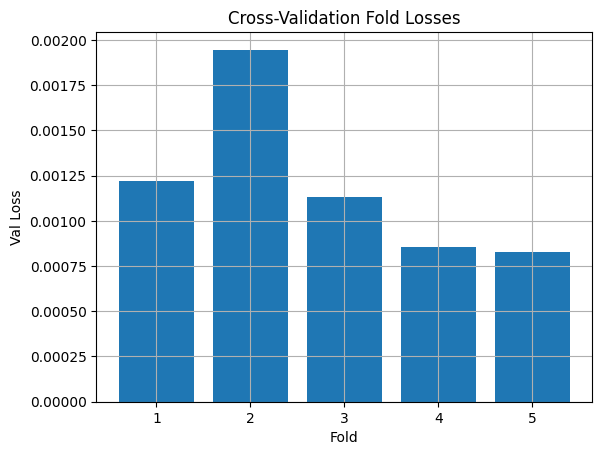

In [ ]:
plt.bar(range(1, len(val_losses) + 1), val_losses)
plt.xlabel('Fold')
plt.ylabel('Val Loss')
plt.title('Cross-Validation Fold Losses')
plt.grid()
plt.show()

### testing

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Homeworks/HW1/r3_fk.keras')


# Predict on the test set
Y_pred_test = model.predict(X_test)

# MSE
test_loss = tf.reduce_mean(tf.square(Y_test - Y_pred_test)).numpy()
print(f"\nLoss on test set: {test_loss:.4f}")


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

Loss on test set: 0.0008


In [ ]:

# FK prediction
def FK(model, theta):
    # Reshape to batch size 1
    t = tf.reshape(theta, shape=(1, 9))  # 9-dimensional input
    out = model(t)[:, :2]  # take only first two values predicted (ft_x, ft_y)
    # Reshape to 1D vector
    out = tf.reshape(out, shape=(2,))  # 2-dimensional output (ft_x, ft_y)
    return out

# learned Jacobian
@tf.function
def FK_Jacobian(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = FK(model, x)
    return tape.jacobian(y, x)[:, :3]  # consider only the first three elements (j0, j1, j2)


# single test sample
sample_input = X_test[0]

from tabulate import tabulate

fk_output = FK(model, sample_input)
learned_jacobian_matrix = FK_Jacobian(model, sample_input)
print("\nForward Kinematics Output (FK):", fk_output.numpy())
print("\nLEARNED JACOBIAN MATRIX:")
print(tabulate(learned_jacobian_matrix.numpy(), tablefmt="fancy_grid"))



Forward Kinematics Output (FK): [ 0.29592678 -0.03024209]

LEARNED JACOBIAN MATRIX:
╒════════════╤══════════╤═════════════╕
│ -0.0114507 │ 0.078813 │ -0.00666431 │
├────────────┼──────────┼─────────────┤
│  0.351694  │ 0.123133 │  0.114785   │
╘════════════╧══════════╧═════════════╛


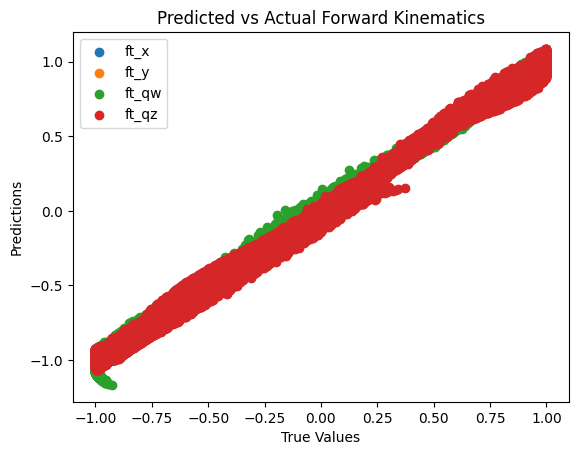

In [ ]:
plt.scatter(Y_test[:, 0], Y_pred_test[:, 0], label="ft_x")
plt.scatter(Y_test[:, 1], Y_pred_test[:, 1], label="ft_y")
plt.scatter(Y_test[:, 2], Y_pred_test[:, 2], label="ft_qw")
plt.scatter(Y_test[:, 3], Y_pred_test[:, 3], label="ft_qz")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Predicted vs Actual Forward Kinematics")
plt.legend()
plt.show()


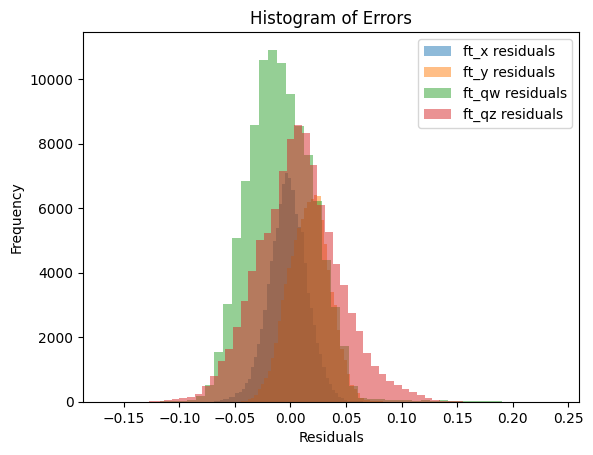

In [ ]:
residuals = Y_test - Y_pred_test

plt.hist(residuals[:, 0], bins=50, alpha=0.5, label="ft_x residuals")
plt.hist(residuals[:, 1], bins=50, alpha=0.5, label="ft_y residuals")
plt.hist(residuals[:, 2], bins=50, alpha=0.5, label="ft_qw residuals")
plt.hist(residuals[:, 3], bins=50, alpha=0.5, label="ft_qz residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Errors")
plt.legend()
plt.show()


# **R5**

## load data and data processing

In [ ]:
train_file = '/content/drive/My Drive/Colab Notebooks/Machine Learning/Homeworks/HW1/r5_500_100k.csv'
df_train = pd.read_csv(train_file, sep=';', header=0)
print('Train file loaded, samples: %d' %(df_train.shape[0]))
print('training dataset:\n')
print(df_train.head())

test_file = '/content/drive/My Drive/Colab Notebooks/Machine Learning/Homeworks/HW1/r5_1000_100k.csv'
df_test = pd.read_csv(test_file, sep=';', header=0)
print('\n\n\nTest file loaded, samples: %d' %(df_test.shape[0]))
print('testing dataset:\n')
print(df_test.head())


from sklearn.model_selection import train_test_split

print('\n\n')
X = df_train[['j0', 'j1', 'j2', 'j3', 'j4', 'cos(j0)', 'cos(j1)', 'cos(j2)', 'cos(j3)', 'cos(j4)', 'sin(j0)', 'sin(j1)', 'sin(j2)', 'sin(j3)', 'sin(j4)']].values # features
Y = df_train[['ft_x', 'ft_y', 'ft_z', 'ft_qw', 'ft_qx', 'ft_qy', 'ft_qz']].values # target
# split data into training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X_train: ', X_train.shape, '\tY_train: ', Y_train.shape, '\n')
print('X_val: ', X_val.shape, '\tY_val: ', Y_val.shape, '\n')

X_test = df_test[['j0', 'j1', 'j2', 'j3', 'j4', 'cos(j0)', 'cos(j1)', 'cos(j2)', 'cos(j3)', 'cos(j4)', 'sin(j0)', 'sin(j1)', 'sin(j2)', 'sin(j3)', 'sin(j4)']].values # features
Y_test = df_test[['ft_x', 'ft_y', 'ft_z', 'ft_qw', 'ft_qx', 'ft_qy', 'ft_qz']].values # target
print('X_test: ', X_test.shape, '\tY_test: ', Y_test.shape)


Train file loaded, samples: 100000
training dataset:

      j0     j1     j2     j3     j4  cos(j0)  cos(j1)  cos(j2)  cos(j3)  \
0  0.000  0.000  0.000  0.000  0.000    1.000    1.000    1.000    1.000   
1  0.005  0.027  0.011 -0.007 -0.002    1.000    1.000    1.000    1.000   
2  0.041  0.067  0.056 -0.027 -0.027    0.999    0.998    0.998    1.000   
3  0.097  0.122  0.127 -0.049 -0.090    0.995    0.993    0.992    0.999   
4  0.177  0.187  0.224 -0.099 -0.174    0.984    0.983    0.975    0.995   

   cos(j4)  ...  sin(j2)  sin(j3)  sin(j4)   ft_x   ft_y   ft_z  ft_qw  ft_qx  \
0    1.000  ...    0.000    0.000    0.000  0.000  0.000  0.590  1.000  0.000   
1    1.000  ...    0.011   -0.007   -0.002  0.015  0.000  0.590  1.000 -0.001   
2    1.000  ...    0.056   -0.027   -0.027  0.043  0.005  0.588  0.999 -0.015   
3    0.996  ...    0.126   -0.049   -0.090  0.085  0.019  0.581  0.993 -0.049   
4    0.985  ...    0.223   -0.099   -0.173  0.130  0.044  0.566  0.979 -0.099   

  

In [ ]:
# Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
# Convert to tensors TensorFlow (float32)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)

X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)

X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.float32)

In [ ]:
# select a random subset of the samples

train_indices = np.random.choice(X_train.shape[0], size=1000, replace=False)
X_train = tf.convert_to_tensor(X_train.numpy()[train_indices], dtype=tf.float32)
Y_train = tf.convert_to_tensor(Y_train.numpy()[train_indices], dtype=tf.float32)

val_indices = np.random.choice(X_val.shape[0], size=1000, replace=False)
X_val = tf.convert_to_tensor(X_val.numpy()[val_indices], dtype=tf.float32)
Y_val = tf.convert_to_tensor(Y_val.numpy()[val_indices], dtype=tf.float32)

print('X_train: ', X_train.shape, '\tY_train: ', Y_train.shape, '\n')
print('X_val: ', X_val.shape, '\tY_val: ', Y_val.shape, '\n')

X_train:  (1000, 15) 	Y_train:  (1000, 7) 

X_val:  (1000, 15) 	Y_val:  (1000, 7) 



## model

### training - hyperparameter tuning, cross validation

In [ ]:
# Deep NN

from sklearn.model_selection import ParameterGrid
import os
import joblib

# --------------------------------------------- hyperparameter tuning

# Define the model wrapper
def build_model(units=12, learning_rate=1e-3, num_layers=10):
    model = Sequential()
    model.add(Input(shape=(15,), name="input_layer"))
    for i in range(num_layers):
        model.add(Dense(units, activation='relu', name=f"hidden_layer_{i + 1}"))
    model.add(Dense(7, activation='linear', name="output_layer"))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Wrap the model using SciKeras
model = KerasRegressor(model=build_model, batch_size=32, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__units': [4, 16, 30],  # Number of neurons in each hidden layer
    'model__learning_rate': [1e-5, 1e-3, 1e-1],  # Learning rates
    'model__num_layers': [5, 15, 60],
    'epochs': [10, 50, 100],  # Epochs
}

# define grid search with cross-validation
grid_search_results = []
grid_search = None


# Perform the search
param_combinations = list(ParameterGrid(param_grid))
num_combinations = len(param_combinations)

for i, params in enumerate(param_combinations):

    # Set the parameters for the model
    model.set_params(**params)

    # Perform the training (fit the model)
    grid_search_results.append({'params': params})


    model.fit(X_train.numpy(), Y_train.numpy())  # Fit the model
    Y_pred = model.predict(X_val.numpy())
    grid_search_results[i]['mse'] = mean_squared_error(Y_val.numpy(), Y_pred)



df_results = pd.DataFrame(grid_search_results)
# Save the DataFrame to a CSV file
output_dir = '/content/scikeras_tuner_data_r5'
os.makedirs(output_dir, exist_ok=True)
results_csv = os.path.join(output_dir, 'grid_search_results.csv')
csv_path = os.path.join(output_dir, 'grid_search_results.csv')
df_results.to_csv(csv_path, index=False)

# Print the results for each combination of hyperparameters tested
print("\nResults for all hyperparameter combinations:")
for i, result in enumerate(grid_search_results):
    print(f"Combination {i + 1}:")
    print(f"Parameters: {result['params']}")
    print(f"MSE: {result.get('mse', 'Not completed')}")
    print("-" * 50)

# Get the best parameters
best_params = min(grid_search_results, key=lambda x: x['mse'])
print(f"\nBest Hyperparameters:")
print(best_params)



Results for all hyperparameter combinations:
Combination 1:
Parameters: {'epochs': 10, 'model__learning_rate': 1e-05, 'model__num_layers': 5, 'model__units': 4}
MSE: 0.15964488685131073
--------------------------------------------------
Combination 2:
Parameters: {'epochs': 10, 'model__learning_rate': 1e-05, 'model__num_layers': 5, 'model__units': 16}
MSE: 0.1965802162885666
--------------------------------------------------
Combination 3:
Parameters: {'epochs': 10, 'model__learning_rate': 1e-05, 'model__num_layers': 5, 'model__units': 30}
MSE: 0.16263654828071594
--------------------------------------------------
Combination 4:
Parameters: {'epochs': 10, 'model__learning_rate': 1e-05, 'model__num_layers': 15, 'model__units': 4}
MSE: 0.16269472241401672
--------------------------------------------------
Combination 5:
Parameters: {'epochs': 10, 'model__learning_rate': 1e-05, 'model__num_layers': 15, 'model__units': 16}
MSE: 0.16172650456428528
-----------------------------------------

In [ ]:
# --------------------------------------------- training with cross validation

# model with the best hyperparameters
best_model = build_model(units=best_params['params']['model__units'], learning_rate=best_params['params']['model__learning_rate'], num_layers=best_params['params']['model__num_layers'])


from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
val_losses = []  # Store test losses for all folds

for train_index, val_index in kf.split(np.arange(len(X_train))):
    print(f"\n--- Fold {fold} ---")

    X_t = tf.gather(X_train, train_index)
    X_v = tf.gather(X_train, val_index)
    Y_t = tf.gather(Y_train, train_index)
    Y_v = tf.gather(Y_train, val_index)
    # Normalization
    X_t = scaler.fit_transform(X_t)
    X_v = scaler.transform(X_v)
    # Convert to tensors TensorFlow (float32)
    X_t = tf.convert_to_tensor(X_t, dtype=tf.float32)
    Y_t = tf.convert_to_tensor(Y_t, dtype=tf.float32)
    X_v = tf.convert_to_tensor(X_v, dtype=tf.float32)
    Y_v = tf.convert_to_tensor(Y_v, dtype=tf.float32)



    best_model.fit(X_t, Y_t, validation_data=(X_v, Y_v),
              epochs=best_params['params']['epochs'], batch_size=32, verbose=0)

    # Evaluate on validation set
    Y_pred = best_model.predict(X_val)
    val_loss = tf.reduce_mean(tf.square(Y_val - Y_pred)).numpy()
    val_losses.append(val_loss)
    print(f"Val loss for fold {fold}: {val_loss:.4f}")
    fold += 1


# Final cross-validated test loss
avg_loss = sum(val_losses) / len(val_losses)
print(f"\nAverage val loss across all folds: {avg_loss:.4f}")


best_model.save('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Homeworks/HW1/r5_fk.keras')



--- Fold 1 ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Val loss for fold 1: 0.0034

--- Fold 2 ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Val loss for fold 2: 0.0026

--- Fold 3 ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Val loss for fold 3: 0.0022

--- Fold 4 ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Val loss for fold 4: 0.0018

--- Fold 5 ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Val loss for fold 5: 0.0018

Average val loss across all folds: 0.0024


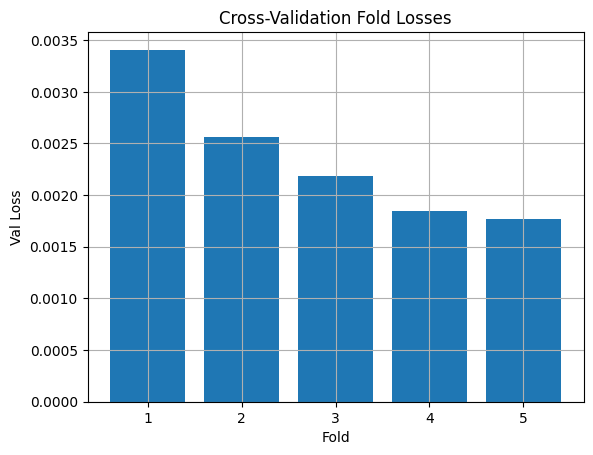

In [ ]:
plt.bar(range(1, len(val_losses) + 1), val_losses)
plt.xlabel('Fold')
plt.ylabel('Val Loss')
plt.title('Cross-Validation Fold Losses')
plt.grid()
plt.show()

### testing

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Homeworks/HW1/r5_fk.keras')


# Predict on the test set
Y_pred_test = model.predict(X_test)

# MSE
test_loss = tf.reduce_mean(tf.square(Y_test - Y_pred_test)).numpy()
print(f"\nLoss on test set: {test_loss:.4f}")



3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

Loss on test set: 0.0018


In [ ]:

# FK prediction
def FK(model, theta):
    # Reshape to batch size 1
    t = tf.reshape(theta, shape=(1, 15))  # 15-dimensional input
    out = model(t)[:, :3]  # take only first three values predicted (ft_x, ft_y, ft_z)
    # Reshape to 1D vector
    out = tf.reshape(out, shape=(3,))  # 3-dimensional output (ft_x, ft_y, ft_z)
    return out

# learned Jacobian
@tf.function
def FK_Jacobian(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = FK(model, x)
    return tape.jacobian(y, x)[:, :5]  # consider only the first five elements (j0, j1, j2, j3, j4)


# single test sample
sample_input = X_test[0]

from tabulate import tabulate

fk_output = FK(model, sample_input)
learned_jacobian_matrix = FK_Jacobian(model, sample_input)
print("\nForward Kinematics Output (FK):", fk_output.numpy())
print("\nLEARNED JACOBIAN MATRIX:")
print(tabulate(learned_jacobian_matrix.numpy(), tablefmt="fancy_grid"))



Forward Kinematics Output (FK): [-0.02942667 -0.04372061  0.5642375 ]

LEARNED JACOBIAN MATRIX:
╒════════════╤════════════╤════════════╤═════════════╤════════════╕
│ 0.072553   │  0.30508   │  0.288758  │  0.0745362  │  0.0906909 │
├────────────┼────────────┼────────────┼─────────────┼────────────┤
│ 0.00317207 │ -0.04407   │  0.0133093 │ -0.00281934 │ -0.0203015 │
├────────────┼────────────┼────────────┼─────────────┼────────────┤
│ 0.0279596  │  0.0124023 │ -0.0183223 │ -0.0156594  │  0.013097  │
╘════════════╧════════════╧════════════╧═════════════╧════════════╛


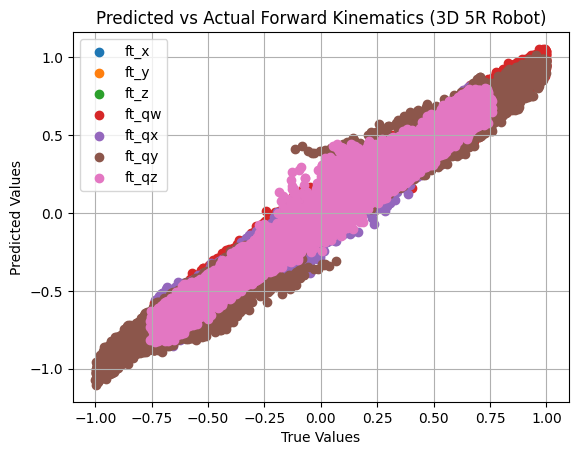

In [ ]:
# Scatter plots for each component
plt.scatter(Y_test[:, 0], Y_pred_test[:, 0], label="ft_x")
plt.scatter(Y_test[:, 1], Y_pred_test[:, 1], label="ft_y")
plt.scatter(Y_test[:, 2], Y_pred_test[:, 2], label="ft_z")
plt.scatter(Y_test[:, 3], Y_pred_test[:, 3], label="ft_qw")
plt.scatter(Y_test[:, 4], Y_pred_test[:, 4], label="ft_qx")
plt.scatter(Y_test[:, 5], Y_pred_test[:, 5], label="ft_qy")
plt.scatter(Y_test[:, 6], Y_pred_test[:, 6], label="ft_qz")

# Plot formatting
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Forward Kinematics (3D 5R Robot)")
plt.legend()
plt.grid(True)
plt.show()


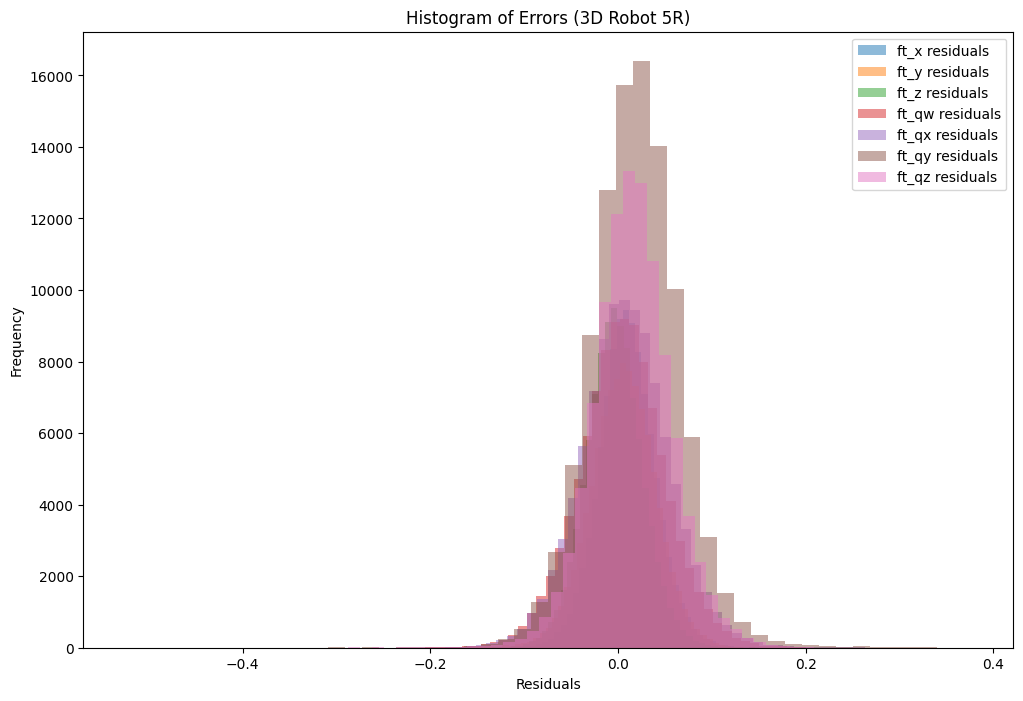

In [ ]:
# Calculate residuals
residuals = Y_test - Y_pred_test

# Plot histograms for all 7 outputs
plt.figure(figsize=(12, 8))

# Define labels for the outputs
labels = ["ft_x", "ft_y", "ft_z", "ft_qw", "ft_qx", "ft_qy", "ft_qz"]

# Iterate through each output and plot its histogram
for i, label in enumerate(labels):
    plt.hist(residuals[:, i], bins=50, alpha=0.5, label=f"{label} residuals")

# Add labels and legend
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Errors (3D Robot 5R)")
plt.legend()
plt.show()
